Let’s start by specifying:

    The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.

    The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).


In [1]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-linear-mnist"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()


Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210526T221366 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


## Data ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done in situ by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn’t onerous, though it would be for larger datasets.

In [6]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 779 ms, sys: 272 ms, total: 1.05 s
Wall time: 1.33 s


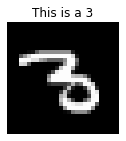

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], "This is a {}".format(train_set[1][30]))

In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)


In [ ]:
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
print("uploaded training data location: {}".format(s3_train_data))


In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, "linear-learner")



## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn’t meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we’ll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed. In this example that takes between 7 and 11 minutes. Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let’s specify our containers. Since we want this notebook to run in all 4 of Amazon SageMaker’s regions, we’ll create a small lookup. More details on algorithm containers can be found in AWS documentation.

In [ ]:
import boto3

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200)

linear.fit({"train": s3_train_data})

## Set up hosting for the model

Now that we’ve trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint. This will allow out to make predictions (or inference) from the model dyanamically.

Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")



In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = "text/csv"
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer



In [ ]:
result = linear_predictor.predict(train_set[0][30:31])
print(result)



In [ ]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [2]:
import pandas as pd

pd.crosstab(
    np.where(test_set[1] == 0, 1, 0), predictions, rownames=["actuals"], colnames=["predictions"]
)

NameError: name 'np' is not defined

## Delete the Endpoint

If you’re ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [3]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

NameError: name 'sagemaker' is not defined